In [1]:
##########################################################################################################################################################################################################################
# Title         : LiDAR data processing with padl: Lidar data segmenation for urban and foresty application 
#
# Purpose       : This Script is written as a final project for the Spatial Python Course 04-GEO-MET3 
#
# Author        : Walid Ghariani; EAGLE MSc Student in Earth Observation and Geoanalysis at JMU Wurzburg| Earth Observation Imegery Analyst at Supervision Earth (linkedin: https://www.linkedin.com/in/walid-ghariani-893365138/) 
#                (E-mail: walid.ghariani@stud-mail.uni-wuerzburg.de | walid11ghariani@gmail.com | walid.ghariani@supervision.earth | Walid.Ghariani@dlr.de) 
#
# Input         : The LiDAR data utilized were downloaded from [Cologne municipality website](https://www.bezreg-koeln.nrw.de/brk_internet/geobasis/hoehenmodelle/3d-messdaten/index.html). 
#                 It contains 3D measurements and the citys surface data collected by aircraft-based laser scanning.
#
# Processing    : pdal pipelines to filter the data, segment the ground and the non-ground, extract the Height Above Ground, Generate the the DTM/DEM, 3D Visualisation and Buildings and trees segmenatation  
#
# python version: Python 3.8.5
##########################################################################################################################################################################################################################

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns
import numpy as np
import pandas as pd
import pdal
import ipyvolume.pylab as p3

import glob
import json
import os
import scipy
from sklearn.cluster import DBSCAN

import rasterio 
from rasterio.plot import show
from rasterio.plot import show_hist

%matplotlib inline

## I. LiDAR data processing whithin a city 

##### Read the lidar data with a laz format 

In [3]:
json = u'''
{
  "pipeline":[
    "./Lidar_Data/lidar_Bonn.laz"
  ]
}'''

In [4]:
p = pdal.Pipeline(json)
p.validate() # check if our JSON and options were good
p.loglevel = 8 #really noisy
count = p.execute()
data = p.arrays[0]
metadata = p.metadata
log = p.log
print('Read', count, 'points with', len(data.dtype), 'dimensions')
print('Dimension names are', data.dtype.names)

Read 999776 points with 13 dimensions
Dimension names are ('X', 'Y', 'Z', 'Intensity', 'ReturnNumber', 'NumberOfReturns', 'ScanDirectionFlag', 'EdgeOfFlightLine', 'Classification', 'ScanAngleRank', 'UserData', 'PointSourceId', 'GpsTime')


##### With this pipeline we add a noise filter "filters.elm": The Extended Local Minimum (ELM) filter marks low points as noise. An outlier filter To remove the noise points altogether by adding a range filter "filters.range"  (by applying a classification value of 7 to the noise points) to the pipeline, downstream from the outlier filter. A Simple Morphological Filter (SMRF) to segment ground (Classification=2) and non-ground (Classification=1). A Height Above Ground (HAG) filter is applied to estimate each point's height above ground. and finally an eignvalue filter which returns the eigenvalues for a given point, based on its k-nearest neighbors. The filter produces three new dimensions (Eigenvalue0, Eigenvalue1, and Eigenvalue2) which will be used later on segment the trees and the buildings based.

In [5]:
json = u'''
{
  "pipeline":[
    "./Lidar_Data/lidar_Bonn.laz",
    {
    "type":"filters.elm",
    "threshold":2.0
    },
     {
    "type":"filters.range",
    "limits":"Classification![7:7]"
    },
    {
      "type":"filters.smrf"
    },
    {
      "type":"filters.hag"
    },
    {
    "type":"filters.eigenvalues",
    "knn":8
}
  ]
}'''

pdal_All = pdal.Pipeline(json)
pdal_All .validate()
count_All = pdal_All .execute()
All_lidar = pdal_All .arrays[0]

Text(0, 0.5, 'Frequency')

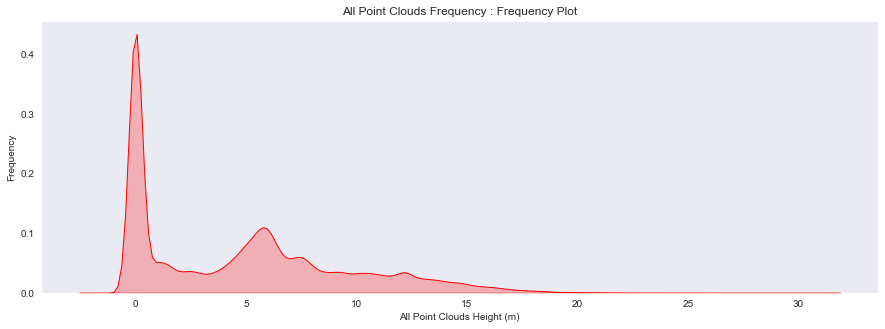

In [8]:
sns.set_style("dark")
plt.figure(figsize=(15,5)) 

sns.kdeplot(All_lidar['HeightAboveGround'], shade=True, color="r")
plt.title("All Point Clouds Frequency : Frequency Plot")
plt.xlabel("All Point Clouds Height (m)")
plt.ylabel("Frequency")

C:\Users\hp\anaconda3\envs\pdalenv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frequency')

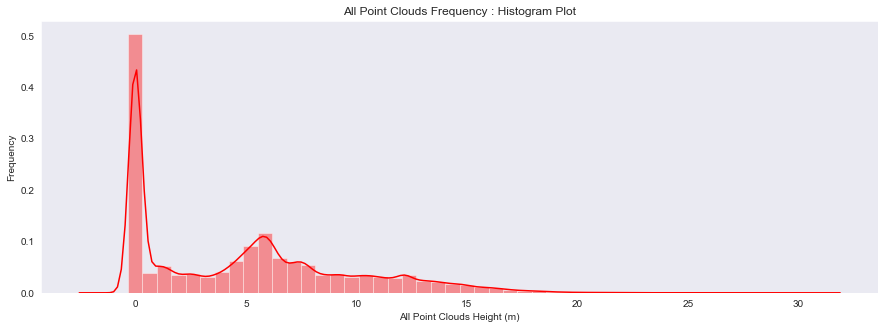

In [9]:
plt.figure(figsize=(15,5)) 

sns.distplot(All_lidar['HeightAboveGround'], color="r")
plt.title("All Point Clouds Frequency : Histogram Plot")
plt.xlabel("All Point Clouds Height (m)")
plt.ylabel("Frequency")

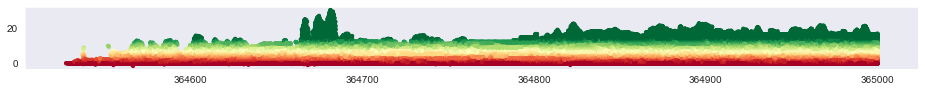

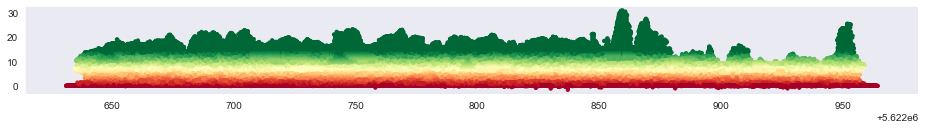

In [10]:
## Lets see if we notice any errors Point Clouds:
fig = plt.figure(figsize=(16,8))
ax = plt.axes(aspect='equal')
ax.scatter(All_lidar['X'],All_lidar['HeightAboveGround'],c=All_lidar['HeightAboveGround'],
           vmin=np.percentile(All_lidar['HeightAboveGround'],5),
           vmax=np.percentile(All_lidar['HeightAboveGround'],95),
           cmap='RdYlGn', s=10)

fig = plt.figure(figsize=(16,8))
ax = plt.axes(aspect='equal')
ax.scatter(All_lidar['Y'],All_lidar['HeightAboveGround'],c=All_lidar['HeightAboveGround'],
           vmin=np.percentile(All_lidar['HeightAboveGround'],5),
           vmax=np.percentile(All_lidar['HeightAboveGround'],95),
           cmap='RdYlGn', s=10)

### Visualizing the Height Above the Ground of only the non-ground Point Clouds

##### Lets segment the non-ground (Classification=1)

In [11]:
json = u'''
{
  "pipeline":[
    "./Lidar_Data/lidar_Bonn.laz",
    {
    "type":"filters.elm",
    "threshold":2.0
    },
     {
    "type":"filters.range",
    "limits":"Classification![7:7]"
    },
    {
      "type":"filters.smrf"
    },
    {
      "type":"filters.hag"
    },
    {
      "type":"filters.range",
      "limits":"Classification[1:1]"
    },
    {
    "type":"filters.eigenvalues",
    "knn":8
}
  ]
}'''

pdal_NG = pdal.Pipeline(json)
pdal_NG.validate()
count_NG = pdal_NG.execute()
NG_lidar = pdal_NG.arrays[0]

Text(0, 0.5, 'Frequency')

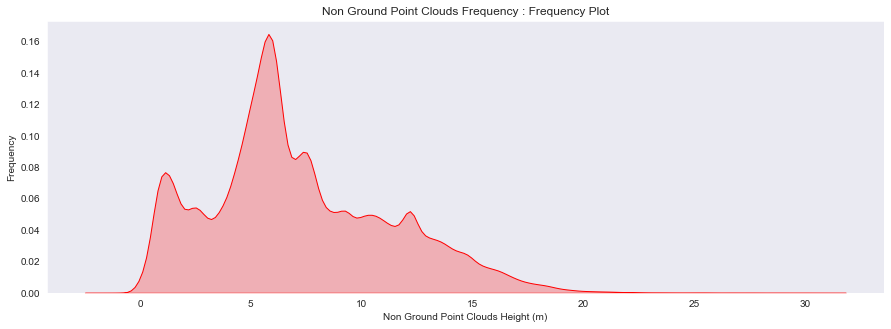

In [12]:
plt.figure(figsize=(15,5)) 

sns.kdeplot(NG_lidar['HeightAboveGround'], shade=True, color="r")
plt.title("Non Ground Point Clouds Frequency : Frequency Plot")
plt.xlabel("Non Ground Point Clouds Height (m)")
plt.ylabel("Frequency")

C:\Users\hp\anaconda3\envs\pdalenv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frequency')

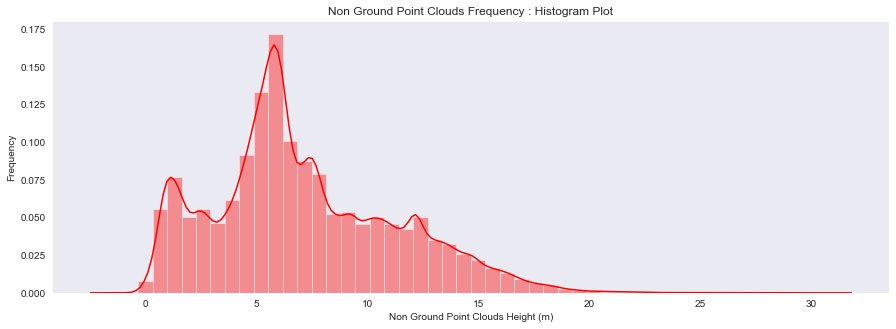

In [13]:
plt.figure(figsize=(15,5)) 

sns.distplot(NG_lidar['HeightAboveGround'],kde=True, color="r")
plt.title("Non Ground Point Clouds Frequency : Histogram Plot")
plt.xlabel("Non Ground Point Clouds Height (m)")
plt.ylabel("Frequency")

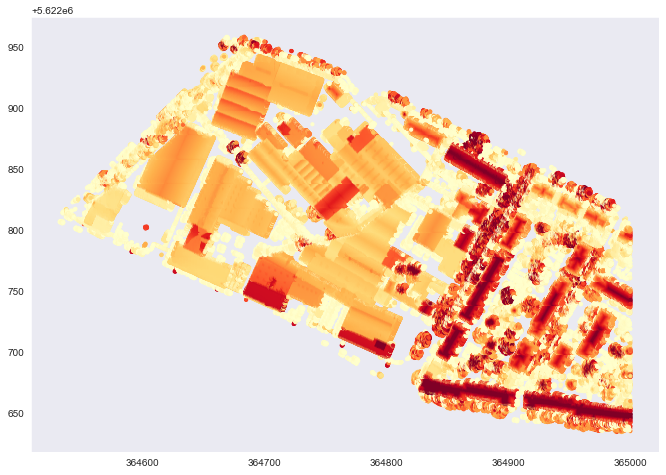

In [14]:
fig = plt.figure(figsize=(16,8))
ax = plt.axes(aspect='equal')
ax.scatter(NG_lidar['X'],NG_lidar['Y'],c=NG_lidar['HeightAboveGround'],
           vmin=np.percentile(NG_lidar['HeightAboveGround'],5),
           vmax=np.percentile(NG_lidar['HeightAboveGround'],95),
           cmap='YlOrRd', s=10)

#### Generate The Digital Elevation Model: DEM

In [106]:
json = u'''
{
  "pipeline":[
    "./Lidar_Data/lidar_Bonn.laz",
    {
    "type":"filters.elm",
    "threshold":2.0
    },
     {
    "type":"filters.range",
    "limits":"Classification![7:7]"
    },
    {
      "type":"filters.smrf"
    },
    {
      "type":"filters.hag"
    },
    {
      "type":"filters.range",
      "limits":"Classification[1:1]"
    },
    {
    "type":"writers.gdal",
    "filename":"./Lidar_Data/Bonn_DEM.tif",
    "output_type":"mean",
    "gdaldriver":"GTiff",
    "resolution":1.0
    }
  ]
}'''
p_DEM = pdal.Pipeline(json)
p_DEM.validate()
count_DEM = p_DEM.execute()

In [15]:
raster_DEM = rasterio.open("./Lidar_Data/Bonn_DEM.tif")
type(raster_DEM)

rasterio.io.DatasetReader

In [16]:
raster_DEM.profile

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 468, 'height': 325, 'count': 1, 'crs': CRS.from_epsg(25832), 'transform': Affine(1.0, 0.0, 364532.13,
       0.0, -1.0, 5622959.86), 'tiled': False, 'interleave': 'band'}

In [17]:
# Projection
print('CRS: ',raster_DEM.crs)

# Affine transform (how raster is scaled, rotated, skewed, and/or translated)
print('Transform: ',raster_DEM.transform)

# Dimensions
print('Width: ',raster_DEM.width)
print('Height: ',raster_DEM.height)

# Number of bands
print('Bands: ',raster_DEM.count)

# resolution 
print("image rsolution: ", raster_DEM.res)

# Bounds of the file
print('Boundary: ',raster_DEM.bounds)

# Driver (data format)
print('Driver: ', raster_DEM.driver)

# No data values for all channels
print('NoData: ', raster_DEM.nodatavals)

# All Metadata for the whole raster dataset
print('Metdata: ', raster_DEM.meta)

CRS:  EPSG:25832
Transform:  | 1.00, 0.00, 364532.13|
| 0.00,-1.00, 5622959.86|
| 0.00, 0.00, 1.00|
Width:  468
Height:  325
Bands:  1
image rsolution:  (1.0, 1.0)
Boundary:  BoundingBox(left=364532.13, bottom=5622634.86, right=365000.13, top=5622959.86)
Driver:  GTiff
NoData:  (-9999.0,)
Metdata:  {'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 468, 'height': 325, 'count': 1, 'crs': CRS.from_epsg(25832), 'transform': Affine(1.0, 0.0, 364532.13,
       0.0, -1.0, 5622959.86)}


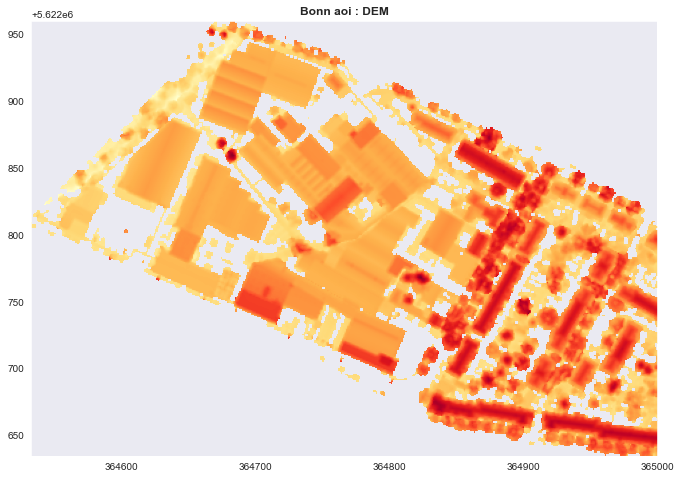

<AxesSubplot:title={'center':'Bonn aoi : DEM'}>

In [18]:
with rasterio.open("./Lidar_Data/Bonn_DEM.tif") as src:
    Bonn_DEM = src.read(1, masked= True)
    transform = src.transform

fig, ax = plt.subplots(figsize = (16,8))    
show(Bonn_DEM, cmap='YlOrRd', transform=transform,title="Bonn aoi : DEM")

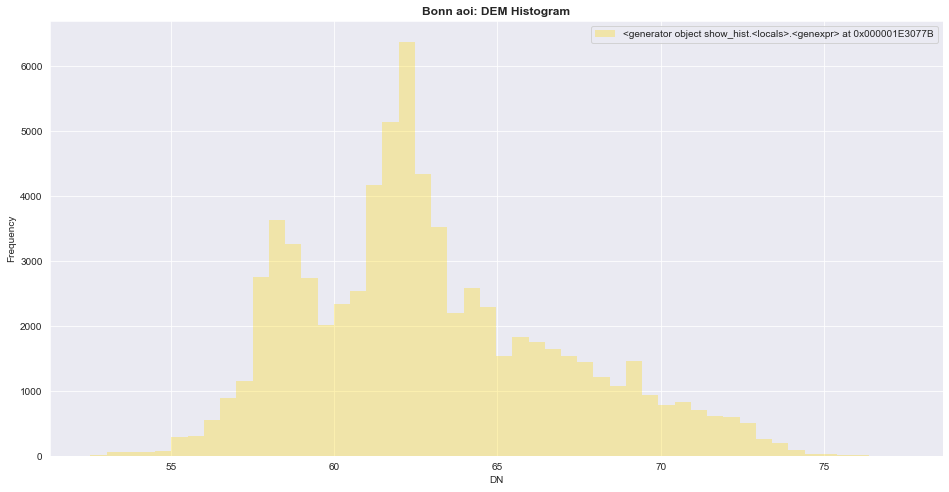

In [19]:
fig, ax = plt.subplots(figsize = (16,8))    

show_hist(Bonn_DEM , bins=50, lw=0.0, stacked=False, alpha=0.3,
          histtype='stepfilled', title="Bonn aoi: DEM Histogram")

### Visualizing the Ground Point Clouds

##### Here we segment the ground (Classification=2)

In [20]:
json = u'''
{
  "pipeline":[
    "./Lidar_Data/lidar_Bonn.laz",
    {
    "type":"filters.elm",
    "threshold":2.0
    },
     {
    "type":"filters.range",
    "limits":"Classification![7:7]"
    },
    {
      "type":"filters.smrf"
    },
    {
      "type":"filters.hag"
    },
    {
      "type":"filters.range",
      "limits":"Classification[2:2]"
    },
    {
    "type":"filters.eigenvalues",
    "knn":8
}
  ]
}'''

pdal_G = pdal.Pipeline(json)
pdal_G.validate()
count_G = pdal_G.execute()
G_lidar = pdal_G.arrays[0]

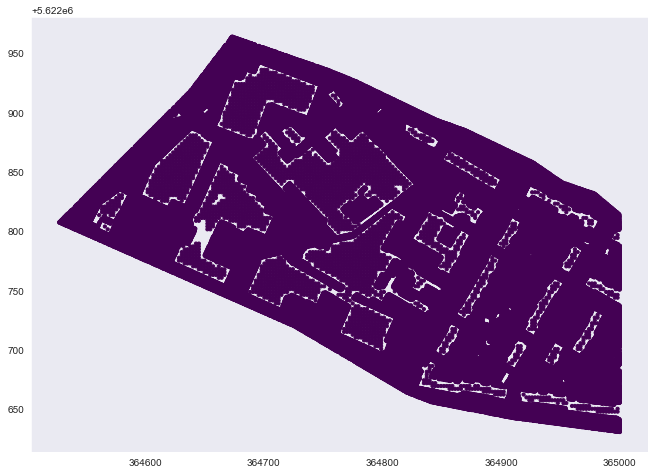

In [21]:
fig = plt.figure(figsize=(16,8))
sns.set_style("dark")
ax = plt.axes(aspect='equal')
ax.scatter(G_lidar['X'],G_lidar['Y'],c=G_lidar['HeightAboveGround'],
           vmin=np.percentile(G_lidar['HeightAboveGround'],5),
           vmax=np.percentile(G_lidar['HeightAboveGround'],95),
           cmap='viridis', s=10)

#### Generate The Digital Terrain Model: DTM

In [86]:
json = u'''
{
  "pipeline":[
    "./Lidar_Data/lidar_Bonn.laz",
    {
    "type":"filters.elm",
    "threshold":2.0
    },
     {
    "type":"filters.range",
    "limits":"Classification![7:7]"
    },
    {
      "type":"filters.smrf"
    },
    {
      "type":"filters.hag"
    },
    {
    "type":"filters.range",
    "limits":"Classification[2:2]"
    },
    {
    "type":"writers.gdal",
    "filename":"./Lidar_Data/Bonn_DTM.tif",
    "output_type":"min",
    "gdaldriver":"GTiff",
    "window_size":3,
    "resolution":1.0
    }
  ]
}'''
p_DTM = pdal.Pipeline(json)
p_DTM.validate()
count = p_DTM.execute()

In [22]:
raster_DTM = rasterio.open("./Lidar_Data/Bonn_DTM.tif")
type(raster_DTM)

rasterio.io.DatasetReader

In [23]:
raster_DTM.profile

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 473, 'height': 334, 'count': 1, 'crs': CRS.from_epsg(25832), 'transform': Affine(1.0, 0.0, 364527.49,
       0.0, -1.0, 5622965.16), 'tiled': False, 'interleave': 'band'}

In [24]:
# Projection
print('CRS: ',raster_DTM.crs)

# Affine transform (how raster is scaled, rotated, skewed, and/or translated)
print('Transform: ',raster_DTM.transform)

# Dimensions
print('Width: ',raster_DTM.width)
print('Height: ',raster_DTM.height)

# Number of bands
print('Bands: ',raster_DTM.count)

# resolution 
print("image rsolution: ", raster_DTM.res)

# Bounds of the file
print('Boundary: ',raster_DTM.bounds)

# Driver (data format)
print('Driver: ', raster_DTM.driver)

# No data values for all channels
print('NoData: ', raster_DTM.nodatavals)

# All Metadata for the whole raster dataset
print('Metdata: ',raster_DTM.meta)

CRS:  EPSG:25832
Transform:  | 1.00, 0.00, 364527.49|
| 0.00,-1.00, 5622965.16|
| 0.00, 0.00, 1.00|
Width:  473
Height:  334
Bands:  1
image rsolution:  (1.0, 1.0)
Boundary:  BoundingBox(left=364527.49, bottom=5622631.16, right=365000.49, top=5622965.16)
Driver:  GTiff
NoData:  (-9999.0,)
Metdata:  {'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 473, 'height': 334, 'count': 1, 'crs': CRS.from_epsg(25832), 'transform': Affine(1.0, 0.0, 364527.49,
       0.0, -1.0, 5622965.16)}


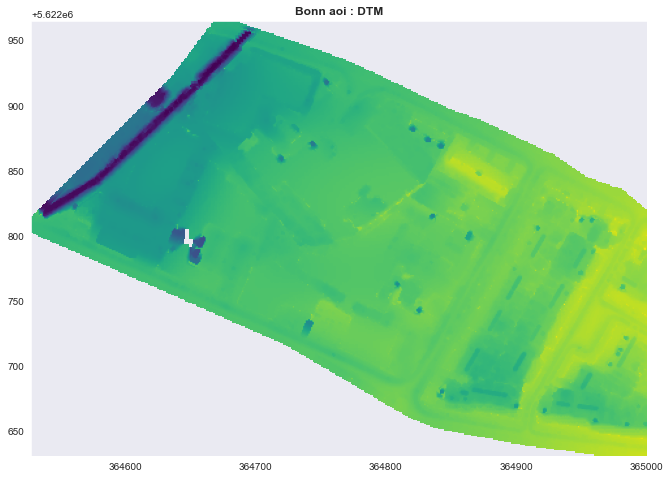

<AxesSubplot:title={'center':'Bonn aoi : DTM'}>

In [25]:
with rasterio.open("./Lidar_Data/Bonn_DTM.tif") as src:
    Bonn_DTM = src.read(1, masked= True)
    transform = src.transform

fig, ax = plt.subplots(figsize = (16,8))    
show(Bonn_DTM, cmap='viridis', transform=transform,title="Bonn aoi : DTM")

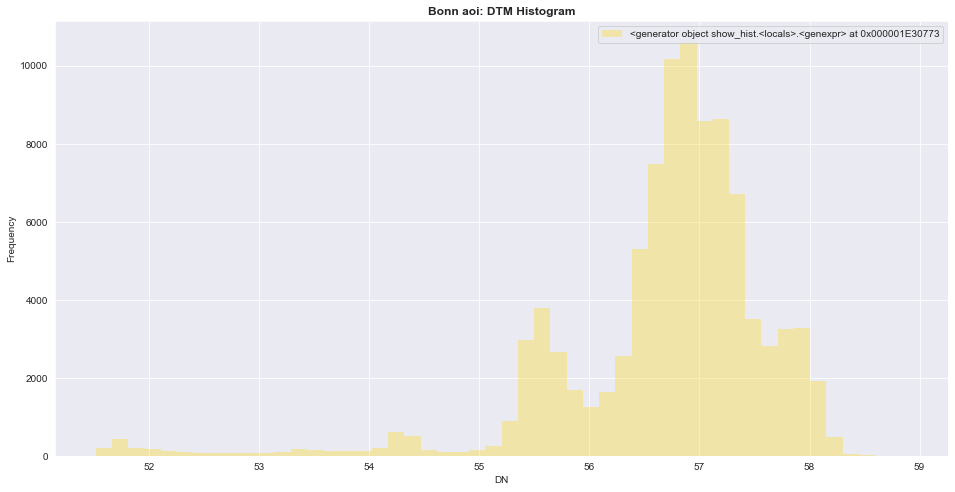

In [26]:
fig, ax = plt.subplots(figsize = (16,8))    

show_hist(Bonn_DTM , bins=50, lw=0.0, stacked=False, alpha=0.3,
          histtype='stepfilled', title="Bonn aoi: DTM Histogram")

### Visualizing the Point Clouds in 3D

In [27]:
## 1. Visualizing all point clouds 

In [28]:
Info = All_lidar.dtype.descr
cols = [col for col, __ in Info ]
DF = pd.DataFrame({col: All_lidar[col] for col in cols})
DF['X_0'] = DF['X']
DF['Y_0'] = DF['Y']
DF['Z_0'] = DF['Z']
DF['X'] = DF['X'] - DF['X_0'].min()
DF['Y'] = DF['Y'] - DF['Y_0'].min()
DF['Z'] = DF['Z'] - DF['Z_0'].min()

In [29]:
DF.head()

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,UserData,PointSourceId,GpsTime,HeightAboveGround,Eigenvalue0,Eigenvalue1,Eigenvalue2,X_0,Y_0,Z_0
0,5.68,175.14,5.79,0,1,2,0,0,1,0.0,0,0,0.0,0.88,0.018664,0.152578,0.352578,364533.17,5622806.30,57.31
1,6.73,176.48,5.81,0,1,2,0,0,1,0.0,0,0,0.0,0.88,0.012717,0.080678,0.476969,364534.22,5622807.64,57.33
2,7.32,176.26,5.87,0,1,2,0,0,1,0.0,0,0,0.0,0.96,0.012046,0.096996,0.205670,364534.81,5622807.42,57.39
3,8.18,183.55,5.94,0,1,2,0,0,1,0.0,0,0,0.0,0.84,0.000923,0.039226,0.083560,364535.67,5622814.71,57.46
4,9.71,185.87,9.98,0,1,2,0,0,1,0.0,0,0,0.0,4.52,0.005325,0.164800,0.252901,364537.20,5622817.03,61.50


In [30]:
fig = p3.figure(width=1000)
fig.xlabel='Y'
fig.ylabel='Z'
fig.zlabel='X'
AllPoints = p3.scatter(DF['Y'], DF['Z'], DF['X'], color='red', size=.2)
p3.squarelim()
p3.show()

In [31]:
## 2. the point cloud data classified as non Ground

In [32]:
Info_NG = NG_lidar.dtype.descr
cols_NG = [col for col, __ in Info_NG ]
DF_NG = pd.DataFrame({col: NG_lidar[col] for col in cols_NG})
DF_NG['X_0'] = DF_NG['X']
DF_NG['Y_0'] = DF_NG['Y']
DF_NG['Z_0'] = DF_NG['Z']
DF_NG['X'] = DF_NG['X'] - DF_NG['X_0'].min()
DF_NG['Y'] = DF_NG['Y'] - DF_NG['Y_0'].min()
DF_NG['Z'] = DF_NG['Z'] - DF_NG['Z_0'].min()

In [33]:
DF_NG.head()

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,UserData,PointSourceId,GpsTime,HeightAboveGround,Eigenvalue0,Eigenvalue1,Eigenvalue2,X_0,Y_0,Z_0
0,1.04,171.44,5.26,0,1,2,0,0,1,0.0,0,0,0.0,0.88,0.008506,0.095488,0.431856,364533.17,5622806.30,57.31
1,2.09,172.78,5.28,0,1,2,0,0,1,0.0,0,0,0.0,0.88,0.009733,0.131040,0.297683,364534.22,5622807.64,57.33
2,2.68,172.56,5.34,0,1,2,0,0,1,0.0,0,0,0.0,0.96,0.012046,0.096996,0.205670,364534.81,5622807.42,57.39
3,3.54,179.85,5.41,0,1,2,0,0,1,0.0,0,0,0.0,0.84,0.000944,0.022329,0.072546,364535.67,5622814.71,57.46
4,5.07,182.17,9.45,0,1,2,0,0,1,0.0,0,0,0.0,4.52,0.005325,0.164800,0.252901,364537.20,5622817.03,61.50


In [34]:
## Viz the highest data
DF_NG.sort_values(by='HeightAboveGround',ascending=False).head() # the heighest Point clouds is about 31m

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,UserData,PointSourceId,GpsTime,HeightAboveGround,Eigenvalue0,Eigenvalue1,Eigenvalue2,X_0,Y_0,Z_0
117616,149.35,224.65,35.27,0,1,2,0,0,1,0.0,0,0,0.0,30.99,0.070169,0.176848,0.376074,364681.48,5622859.51,87.32
117606,149.21,224.04,34.94,0,1,2,0,0,1,0.0,0,0,0.0,30.87,0.043662,0.137172,0.257992,364681.34,5622858.90,86.99
119350,149.19,225.83,34.48,0,1,2,0,0,1,0.0,0,0,0.0,30.49,0.021212,0.167961,0.552210,364681.32,5622860.69,86.53
515868,149.30,224.55,34.67,0,2,2,0,0,1,0.0,0,0,0.0,30.39,0.033413,0.165032,0.252905,364681.43,5622859.41,86.72
117629,149.51,224.84,34.36,0,1,2,0,0,1,0.0,0,0,0.0,30.36,0.074313,0.213312,0.313307,364681.64,5622859.70,86.41


In [35]:
fig = p3.figure(width=1000)
fig.xlabel='Y'
fig.ylabel='Z'
fig.zlabel='X'
NG_pts = p3.scatter(DF_NG['Y'], DF_NG['Z'], DF_NG['X'], color='red', size=.2)
p3.squarelim()
p3.show()

In [36]:
## 3. the point cloud data classified as Ground

In [37]:
Info_G = G_lidar.dtype.descr
cols_G = [col for col, __ in Info_G ]
DF_G = pd.DataFrame({col: G_lidar[col] for col in cols_G})
DF_G['X_0'] = DF_G['X']
DF_G['Y_0'] = DF_G['Y']
DF_G['Z_0'] = DF_G['Z']
DF_G['X'] = DF_G['X'] - DF_G['X_0'].min()
DF_G['Y'] = DF_G['Y'] - DF_G['Y_0'].min()
DF_G['Z'] = DF_G['Z'] - DF_G['Z_0'].min()

In [38]:
DF_G.head()

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,UserData,PointSourceId,GpsTime,HeightAboveGround,Eigenvalue0,Eigenvalue1,Eigenvalue2,X_0,Y_0,Z_0
0,0.00,176.72,4.89,0,1,1,0,0,2,0.0,0,0,0.0,0.0,0.000078,0.096932,0.177931,364527.49,5622807.88,56.41
1,0.24,176.42,4.92,0,1,1,0,0,2,0.0,0,0,0.0,0.0,0.000088,0.066230,0.155821,364527.73,5622807.58,56.44
2,0.34,176.86,4.92,0,1,1,0,0,2,0.0,0,0,0.0,0.0,0.000078,0.096932,0.177931,364527.83,5622808.02,56.44
3,0.61,176.58,4.92,0,1,1,0,0,2,0.0,0,0,0.0,0.0,0.000088,0.066230,0.155821,364528.10,5622807.74,56.44
4,0.74,177.04,4.94,0,1,1,0,0,2,0.0,0,0,0.0,0.0,0.000016,0.108484,0.128382,364528.23,5622808.20,56.46


In [39]:
fig = p3.figure(width=1000)
fig.xlabel='Y'
fig.ylabel='Z'
fig.zlabel='X'
G_pts = p3.scatter(DF_G['Y'], DF_G['Z'], DF_G['X'], color='lightgrey', size=.2)
p3.squarelim()
p3.show()

In [40]:
## 4. Lets visualize the Ground and non ground in one plot 

In [41]:
fig = p3.figure(width=1000)

# Define all points and ground points for plot
NonGround = p3.scatter(DF_NG['Y'], DF_NG['Z'], DF_NG['X'], color='red', size=.2)
Ground= p3.scatter(DF_G['Y'], DF_G['Z'], DF_G['X'], color='lightgrey', size=.2)

# Add labels to plot
fig.xlabel='Y'
fig.ylabel='Z'
fig.zlabel='X'

# Append both sets of points to plot
fig.scatters.append(NonGround)
fig.scatters.append(Ground)

p3.squarelim()
p3.show()

### Segmentation of Lidar Data: Buildings and Trees

In [42]:
DF.head()

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,UserData,PointSourceId,GpsTime,HeightAboveGround,Eigenvalue0,Eigenvalue1,Eigenvalue2,X_0,Y_0,Z_0
0,5.68,175.14,5.79,0,1,2,0,0,1,0.0,0,0,0.0,0.88,0.018664,0.152578,0.352578,364533.17,5622806.30,57.31
1,6.73,176.48,5.81,0,1,2,0,0,1,0.0,0,0,0.0,0.88,0.012717,0.080678,0.476969,364534.22,5622807.64,57.33
2,7.32,176.26,5.87,0,1,2,0,0,1,0.0,0,0,0.0,0.96,0.012046,0.096996,0.205670,364534.81,5622807.42,57.39
3,8.18,183.55,5.94,0,1,2,0,0,1,0.0,0,0,0.0,0.84,0.000923,0.039226,0.083560,364535.67,5622814.71,57.46
4,9.71,185.87,9.98,0,1,2,0,0,1,0.0,0,0,0.0,4.52,0.005325,0.164800,0.252901,364537.20,5622817.03,61.50


In [43]:
fig = p3.figure(width=1000)
fig.xlabel='Y'
fig.ylabel='Z'
fig.zlabel='X'
all_points = p3.scatter(DF['Y'], DF['Z'], DF['X'], color='red', size=.2)
p3.squarelim()
p3.show()

In [44]:
# Color ground in grey
DF['ground'] = DF['Classification'] == 2

ground = p3.scatter(DF.loc[DF['ground'],'Y'].values, DF.loc[DF['ground'],'Z'].values, DF.loc[DF['ground'],'X'].values, color='red', size=.2)
non_ground = p3.scatter(DF.loc[~DF['ground'],'Y'].values, DF.loc[~DF['ground'],'Z'].values, DF.loc[~DF['ground'],'X'].values, color='red', size=.2)

fig.scatters.append(ground)
fig.scatters.append(non_ground)

all_points.visible = False
ground.color='lightgrey'

In [45]:
# Visualize the Ground as surface
ground_delaunay = scipy.spatial.Delaunay(DF.loc[DF['ground'],['X','Y']])
ground_surf = p3.plot_trisurf(DF.loc[DF['ground'],'Y'], DF.loc[DF['ground'],'Z'], DF.loc[DF['ground'],'X'], ground_delaunay.simplices, color='lightgrey')
fig.meshes.append(ground_surf)
ground.visible=False

In [47]:
# Color points according to flatness
DF['Flatness'] = DF['Eigenvalue0'] 
non_ground.color=matplotlib.cm.RdYlGn(DF.loc[~DF['ground'],'Flatness']*4)[:,0:3]

In [48]:
# Separate between trees and the rest
DF['tree_potential'] = (DF['Classification']==1) & (DF['HeightAboveGround'] >= 2) & (DF['Flatness'] > .05) &  (DF['NumberOfReturns'] - DF['ReturnNumber'] >= 1) 
DF['other'] = ~DF['ground'] & ~DF['tree_potential']

In [49]:
tree_potential = p3.scatter(DF.loc[DF['tree_potential'],'Y'].values, DF.loc[DF['tree_potential'],'Z'].values, DF.loc[DF['tree_potential'],'X'].values, color=matplotlib.cm.RdYlGn(DF.loc[DF['tree_potential'],'Flatness']*4)[:,0:3], size=.2)
other = p3.scatter(DF.loc[DF['other'],'Y'].values, DF.loc[DF['other'],'Z'].values, DF.loc[DF['other'],'X'].values, color=matplotlib.cm.RdYlGn(DF.loc[DF['other'],'Flatness']*4)[:,0:3], size=.2)
non_ground.visible=False
tree_potential.color='darkgreen'
other.color='red'

In [50]:
#Hide non-tree
other.visible=False

In [51]:
#Function to Find local maxima of points in a pointcloud.
def local_max(coords, radius, density_threshold=0):

    max_box = coords.copy()
    for i in range(2):
        max_box['X{}'.format(i)] = ((coords['X']/radius + i) /2).astype(int)*2
        max_box['Y{}'.format(i)] = ((coords['Y']/radius + i) /2).astype(int)*2
    max_box['X_'] = (coords['X']/radius).astype(int)
    max_box['Y_'] = (coords['Y']/radius).astype(int)
    for i in range(2):
        for j in range(2):
            max_box[str(i)+str(j)] = max_box.groupby(['X{}'.format(i), 'Y{}'.format(j)])['Z'].transform(np.max)
    density = max_box.groupby(['X_','Y_'])['Z'].transform(len)
    is_max = (max_box['00'] == max_box['10']) & (max_box['10'] == max_box['01']) & (max_box['01'] == max_box['11']) & (max_box['11'] == coords['Z'])
    return coords[is_max & (density >= (density_threshold))]

In [52]:
Tree_loc = local_max(DF.loc[DF['tree_potential'],['X','Y','Z','HeightAboveGround']], radius=3, density_threshold=15)

In [53]:
Tree_loc.head()

,X,Y,Z,HeightAboveGround
6513,207.47,158.44,21.92,16.36
9775,286.02,120.95,23.25,17.70
13292,216.64,182.67,19.22,13.97
15340,333.84,25.83,21.29,15.47
15877,346.26,27.26,18.15,12.23


In [54]:
dbscan = DBSCAN(eps=1.2, min_samples=10).fit(DF.loc[DF['tree_potential'],['X','Y','Z']].values)

In [55]:
dbscan

DBSCAN(eps=1.2, min_samples=10)

In [56]:
HDF=DF.loc[DF['tree_potential']]

In [57]:
HDF['tree_idx'] = dbscan.labels_

print("Number of tree points:",len(HDF))
print("Unique clusters:",len(HDF['tree_idx'].unique()))

Number of tree points: 23994
Unique clusters: 140


<ipython-input-57-5f70ad4f1bf5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HDF['tree_idx'] = dbscan.labels_


In [58]:
# Generate colourmap for individual clusters
cmap = matplotlib.cm.get_cmap('flag')

normalize = matplotlib.colors.Normalize(vmin=min(HDF['tree_idx']), vmax=max(HDF['tree_idx']))
colors = [cmap(normalize(value)) for value in HDF['tree_idx']]

# Plot clusters of points back onto scatter plot
classified_tree_points = p3.scatter(HDF['Y'].values, HDF['Z'].values, HDF['X'].values, color=colors, size=.2)
tree_potential.visible=False

fig.scatters.append(classified_tree_points)

In [59]:
# Find treetops and place a sphere on each one
treetop_spheres = p3.scatter(Tree_loc['Y'].values, Tree_loc['Z'].values, Tree_loc ['X'].values, color='green', size=.5, marker='sphere')
fig.scatters.append(treetop_spheres)

In [60]:
# Find the tallest tree 
# This method assumes that all significant trees are the tallest in the LiDAR
# Alternatively, the treetop closest to the centre tree could be used
treetop_spheres.visible = False
tallest_tree = pd.DataFrame(Tree_loc.loc[Tree_loc['Z'].idxmax()]).T
tallest_tree_sphere = p3.scatter(tallest_tree['Y'].values, tallest_tree['Z'].values, tallest_tree['X'].values, color='green', size=5, marker='sphere')

In [62]:
tallest_tree_lidar_DF = HDF.loc[HDF['tree_idx'] == 3]
print("Number of points in tallest tree:", len(tallest_tree_lidar_DF))

Number of points in tallest tree: 112


In [63]:
# Volume and height of tree cloud (in cubic metres, expecting coordinate system is metres - UTM WGS84 in this case)
tree_volume = round(scipy.spatial.ConvexHull(tallest_tree_lidar_DF[['X','Y','Z']]).volume,2)
tree_height = round(tallest_tree['HeightAboveGround'].values[0],2)
print("Tree dimensions\n---------------\nVolume:", str(tree_volume)+"m^3", "\nHeight:", str(tree_height)+"m")

Tree dimensions
---------------
Volume: 67.24m^3 
Height: 30.99m
